In [1]:
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import NullFormatter

In [2]:
import warnings
warnings.simplefilter(action='ignore')

# Configuramos el formato por defecto de la 
# librería de visualización Matplotlib.

mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams.update({'font.size': 20})

In [3]:
def cm2inch(cm):
    return cm/2.54

def gaussBckgrnd(x,m,s,M,b0,b1):
    z = (m-x)/s
    gauss = M*np.exp(-0.5*z**2)
    fondo = b0 + b1 * (x - m)
    return gauss + fondo

def tandem(x,m1,s1,M1,m2,s2,M2,b0,b1):
    z1 = (m1-x)/s1
    gauss1 = M1*np.exp(-0.5*z1**2)
    z2 = (m2-x)/s2
    gauss2 = M2*np.exp(-0.5*z2**2)
    mm = (m1 + m2)/2
    fondo = b0 + b1 * (x - mm)
    return gauss1 + gauss2 + fondo

def recta(x,b0,b1,x0):
    return b0 + b1 * (x-x0)

def recta2(x,b0,b1):
    return b0 + b1 *(x)

def gauss(x,m,s,M):
    z = (m-x)/s
    return M*np.exp(-0.5*z**2)

# toma las salidas de curve_fit: parámetros= pot, matriz de covariaza = pcov
# La diagonal de la matriz de covarianza es la covarianza de cada parámetro. Su raíz cuadrada es la desviación estándar.
def statsLinear_tabla(popt,pcov):
    b = popt[0] 
    stdv_b = np.sqrt(pcov[0,0])
    
    m = popt[1] 
    stdv_m = np.sqrt(pcov[1,1])
    print('      m    \t    b')
    print('{0:4.3f}({1:2.3f}) \t {2:4.3f}({3:2.3f})'.format(m,stdv_m,b,stdv_b))
    
def statsGauss_tabla(popt,pcov):
    mu = popt[0] 
    stdv_mu = np.sqrt(pcov[0,0])
    
    s = popt[1]
    s = np.abs(s) # curve_fit puede producir s < 0, sin efecto adverso. 
    stdv_s = np.sqrt(pcov[1,1])
    
    M = popt[2]
    stdv_M = np.sqrt(pcov[2,2])
    
    b0 = popt[3]
    stdv_b0 = np.sqrt(pcov[3,3])
    
    b1 = popt[4]
    stdv_b1 = np.sqrt(pcov[4,4])
    
    I = np.sqrt(2*np.pi)*s*M
    stdv_I = I * np.sqrt((stdv_s/s)**2 + (stdv_M/M)**2) 

    print('   M(c/cnl)      mu(cnl)     sigma(cnl)   I(c) ')
    print('{0:4.2f}({1:2.2f}) &{2:4.1f}({3:2.1f}) &{4:3.1f}({5:2.1f}) &{6:5.0f}({7:3.0f})  \\\\'.format(M,stdv_M,mu,stdv_mu,s,stdv_s,I,stdv_I))

### Pasando los datos de .dat a .csv

In [31]:
stringo = r' C:\Users\PC\OneDrive - Universidad Nacional de Colombia\Documentos\FISICA_2021_01\2021-02\Tecnicas de caracterizacion\Modulo 1 Cristancho\Lab 2'
print(stringo)
A = stringo.replace('\\' ,'\\')
#print(A)

 C:\Users\PC\OneDrive - Universidad Nacional de Colombia\Documentos\FISICA_2021_01\2021-02\Tecnicas de caracterizacion\Modulo 1 Cristancho\Lab 2
 C:\Users\PC\OneDrive - Universidad Nacional de Colombia\Documentos\FISICA_2021_01\2021-02\Tecnicas de caracterizacion\Modulo 1 Cristancho\Lab 2


'\\'

In [127]:
from pathlib import Path

txt_folder = Path(r'C:\Users\PC\OneDrive - Universidad Nacional de Colombia\Documentos\FISICA_2021_01\2021-02\Tecnicas de caracterizacion\Modulo 1 Cristancho\Lab 2').rglob('*.dat')
files = [x for x in txt_folder]
fileslist = list()

for file in files:
    filest = str(file)
    names_dat = filest.split("Lab 2\\")[1]
    print(names_dat)
    fileslist.append(names_dat)

arena-aire.dat
caja.dat
caja_arena_1.dat
caja_arena_3.dat
caja_arena_9.dat


Lo anterior se realizó para tener en una lista los nombres de los datos con extensión .dat.

Lo siguiente es para crear los .csv y pasar los datos a este formato

In [398]:
import csv
for filo in fileslist:
    new = filo.replace("dat","csv")
    #print(new)
    with open(filo,'r') as dat_file, open(new, 'w',newline='') as csv_file:
        #print(dat_file)
        #csv_writer = csv.writer(csv_file)
        for line in dat_file:
            #print(line)
            a = line.replace('\t',',')
            #print(a)
            sep = a.split(',')
            sep[1] = sep[1].split('\n')[0]
            #print(sep)
            #print(a)
            b = csv.writer(csv_file,delimiter=',',quotechar=' ')
            b.writerow(sep)

In [148]:
newiescsv = list()
for filecsv in fileslist:
    newfiles = filecsv.replace('dat','csv')
    newiescsv.append(newfiles)
newiescsv

['arena-aire.csv',
 'caja.csv',
 'caja_arena_1.csv',
 'caja_arena_3.csv',
 'caja_arena_9.csv']

In [399]:
datico = 3 #este parámetro es para ir cogiendo el csv que uno quiere ir trabajando, acá serviriía el loop
newnamedatico = newiescsv[datico].replace('.csv','') 
f0 = pd.read_csv(newiescsv[datico]) #Importanto datos


x0 = f0.iloc[:,0].to_numpy()
y0 = f0.iloc[:,1].to_numpy()

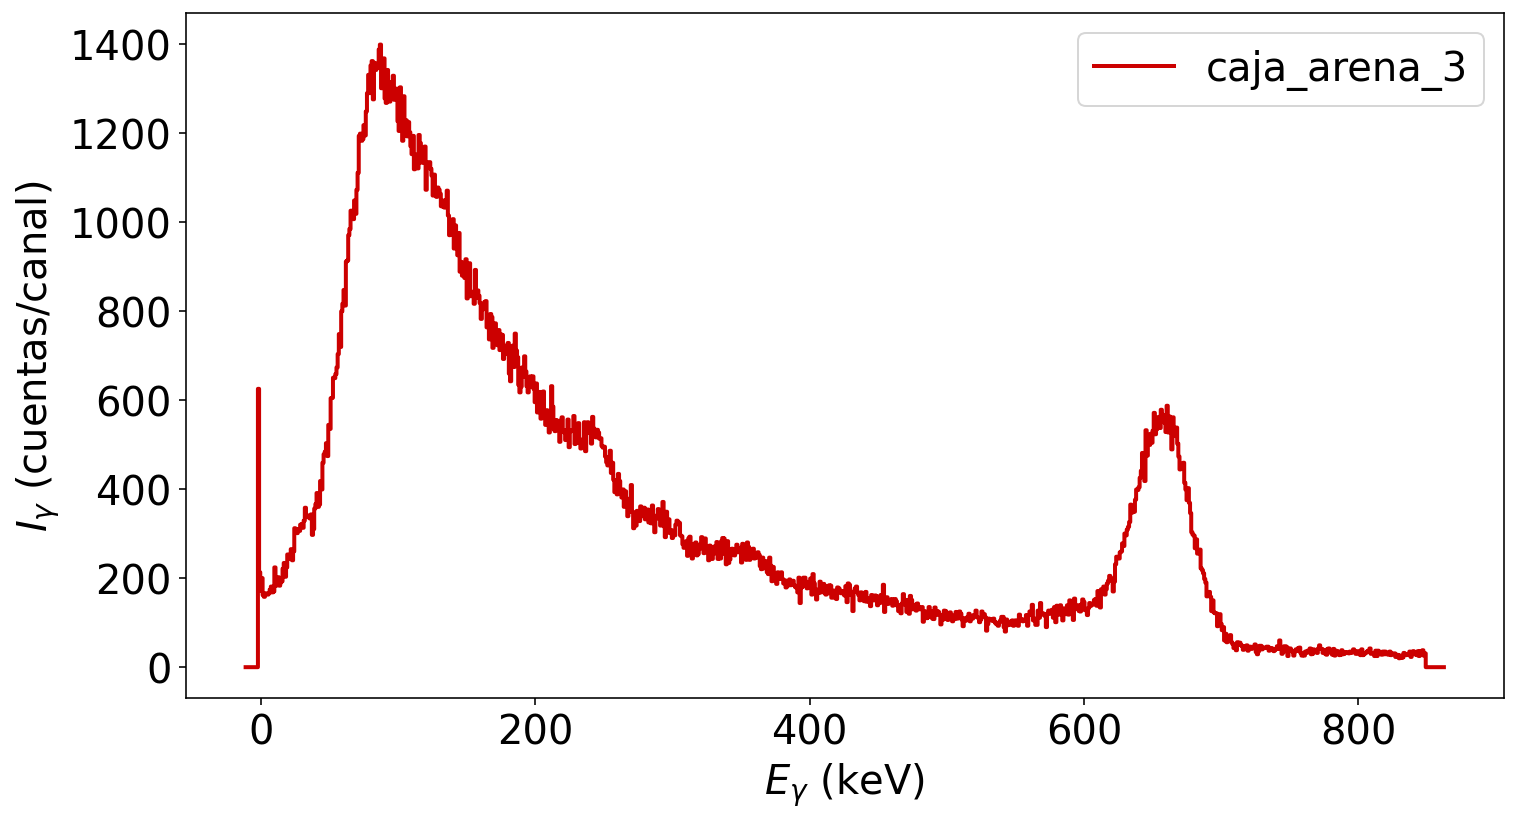

In [390]:

fig, ax = plt.subplots(1,1,figsize=(cm2inch(30.0),cm2inch(16.0)))
plt.plot(x0,y0,drawstyle='steps-mid',linewidth=2,color=(0.8,0,0,1),label= '%s' % newnamedatico   ) #color (R,G,B,intensidad)
ax.set_xlabel(r'$E_{\gamma}$ (keV)')
ax.set_ylabel(r'$I_{\gamma}$ (cuentas/canal)')
plt.legend();

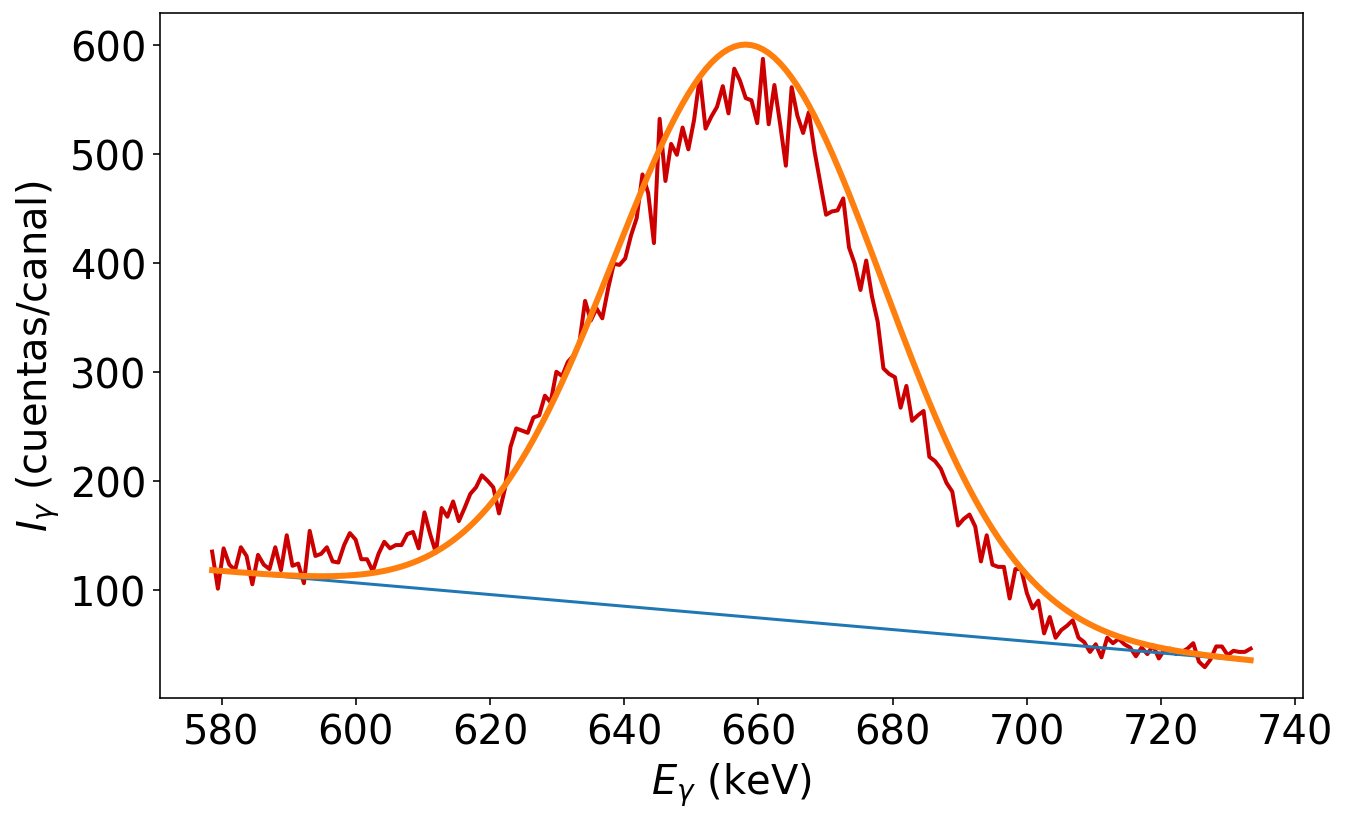

In [393]:
#Seleccionando la zona de interés.
x=x0[690:872] #ojo, esos índices corresponden a las posiciones del vector NO a los valores de energía
y=y0[690:872]
fig, ax =plt.subplots(1,1,figsize=(cm2inch(26.0),cm2inch(16.0)))
ax.plot(x,y,linewidth=2,color=(0.8,0,0,1))
# siguientes líneas: inicialización de los parámetros de ajuste , parámetros puestos a ojo.
mu = 658.5      #mitad de la campana
s = 20        #ancho medio
M = 525       #altura
b0 = 75       #corte con el eje y de la recta
b1 = -75/140  #pendiente de la recta
rf = recta(x,b0,b1,mu)
plt.plot(x,rf)
gf = gaussBckgrnd(x,mu,s,M,b0,b1)
ax.plot(x,gf,lw=3); # Miramos qué tan buenos son los parámetros graficando con ellos (sin ajustar todavía)
ax.set_xlabel(r'$E_{\gamma}$ (keV)')
ax.set_ylabel(r'$I_{\gamma}$ (cuentas/canal)');

In [394]:
p0 = np.array([mu,s,M,b0,b1]) #vector de parámetros para el ajuste
popt, pcov = curve_fit(gaussBckgrnd,x,y,p0,sigma=np.sqrt(y)) #comando curve_fit para ajustar gaussiana y recta
popt #retorna los parámetros de p0 pero ajustados

array([656.79911688,  19.61253752, 477.31614091,  82.6970141 ,
        -0.67131997])

   M(c/cnl)      mu(cnl)     sigma(cnl)   I(c) 
477.32(4.86) &656.8(0.2) &19.6(0.2) &23466(336)  \\


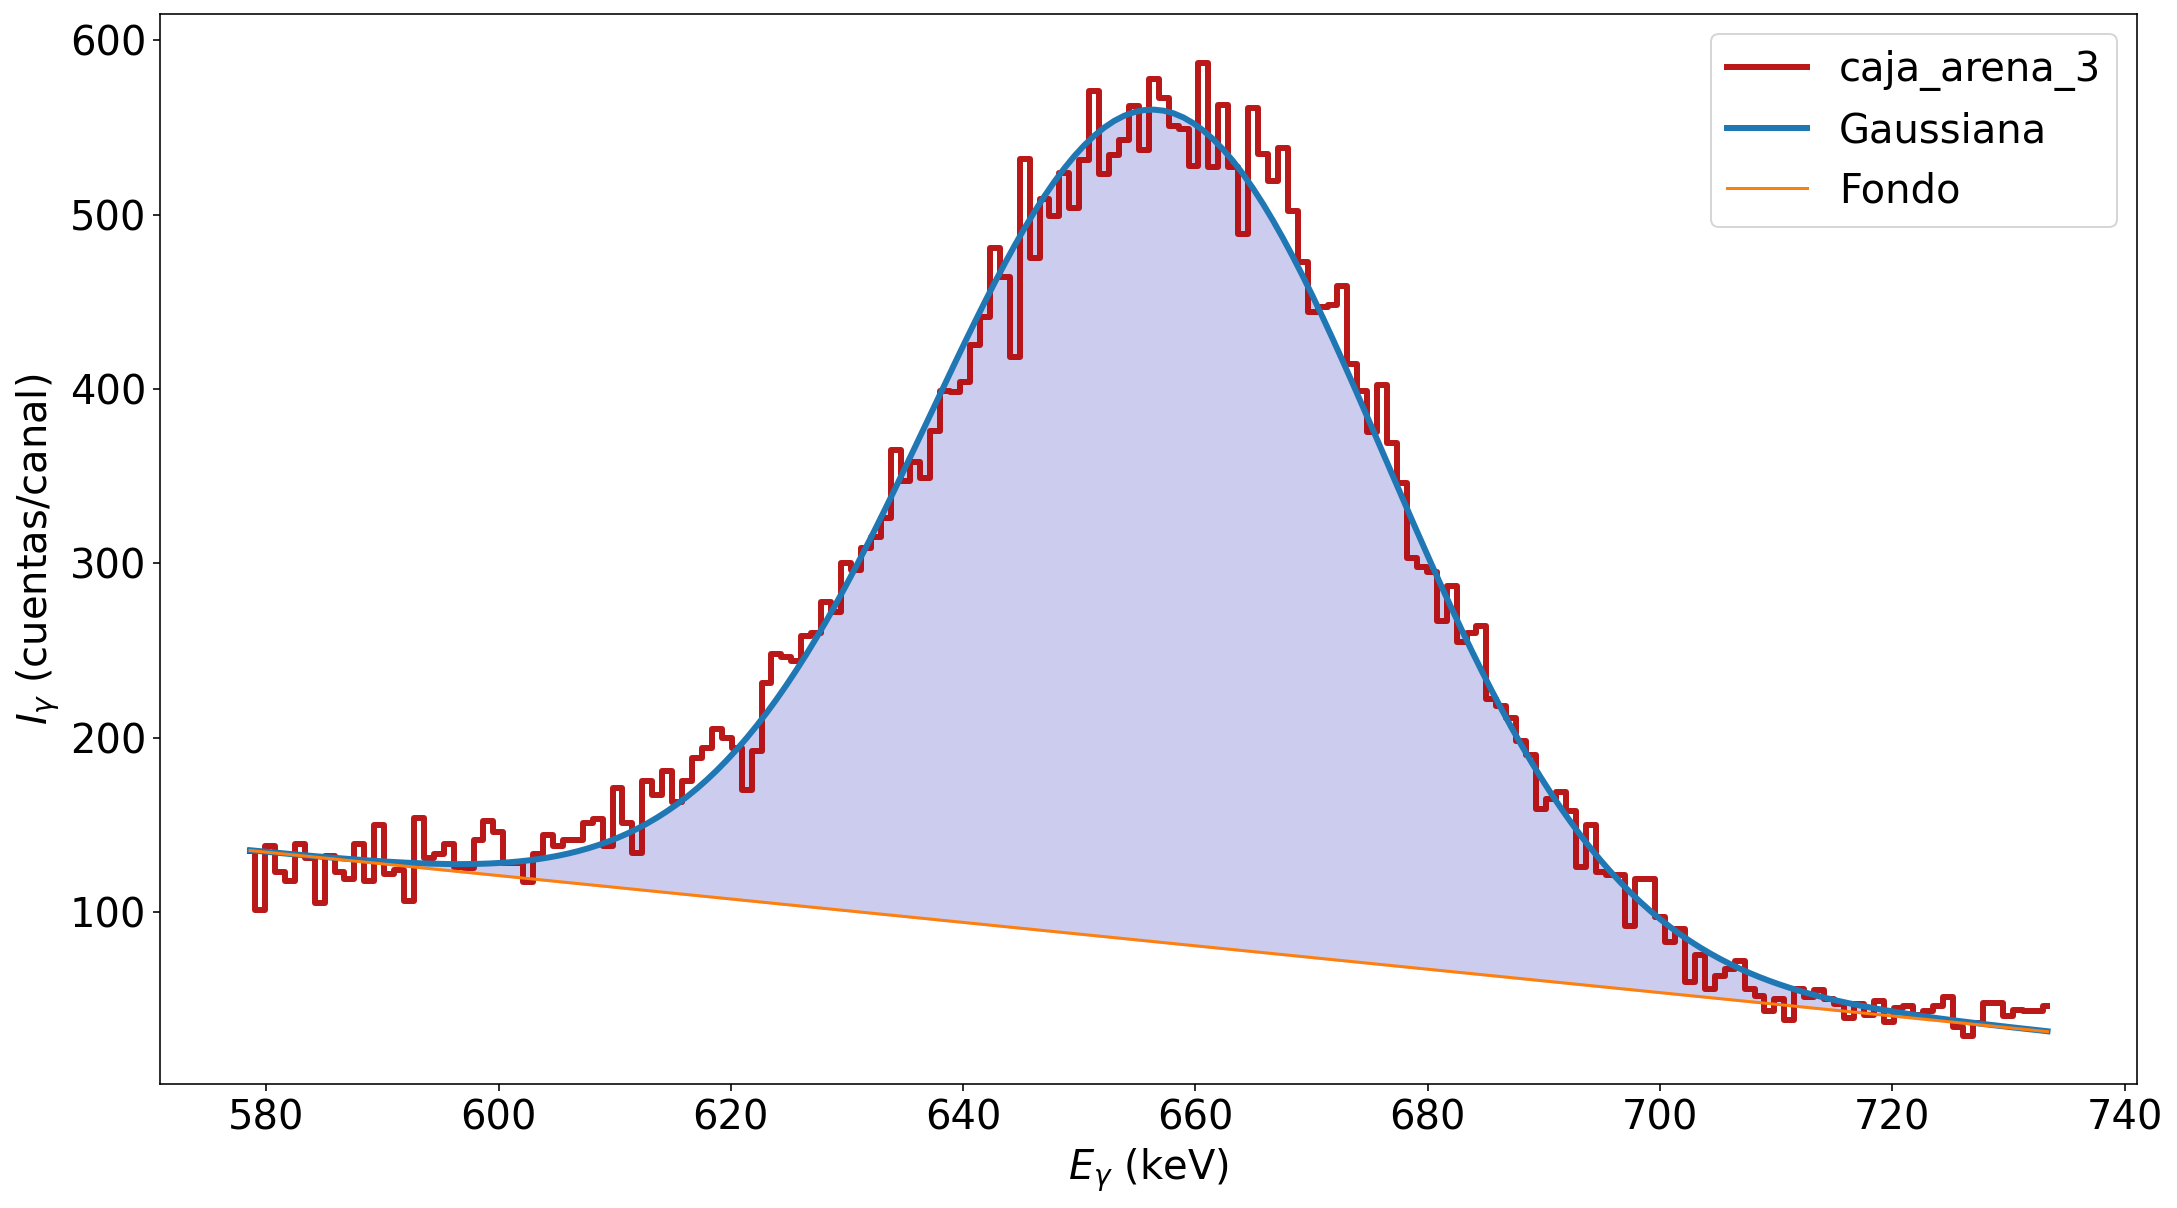

In [395]:
mu,s,M,b0,b1 = popt
y_fit = gaussBckgrnd(x,mu,s,M,b0,b1)  #Gaussiana
r_fit = recta(x,b0,b1,mu)             #Recta

#Graficando
fig, ax = plt.subplots(1,1,figsize=(cm2inch(45.0),cm2inch(25.0)))
datos,= ax.plot(x,y,drawstyle='steps-mid',linewidth=3,color=(0.7,0,0,0.9))
datos.set_label('%s' % newnamedatico)

curva_gauss,= ax.plot(x,y_fit,lw=3)
curva_gauss.set_label('Gaussiana')

recta_gauss,=ax.plot(x,r_fit)
recta_gauss.set_label('Fondo')

ax.fill_between(x,r_fit,y_fit,color=(0,0,0.7,0.2))
ax.set_xlabel(r'$E_{\gamma}$ (keV)')
ax.set_ylabel(r'$I_{\gamma}$ (cuentas/canal)')
ax.legend()

#plt.savefig('%s' % newnamedatico+".png", dpi=150)

#Tabla de parámetros y sus incertiumbres
statsGauss_tabla(popt,pcov) # La salida produce resultados listos para incluir y editar en latex. Pero falta depurar la notación de las incertidumbres...

In [293]:
#Coeficiente de correlación para la Gaussiana
residuals = y- gaussBckgrnd(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print('r={0:0.4f}'.format(np.sqrt(r_squared)))

r=0.9880


## Ajuste semilog para las intensidades y distancias

In [321]:
!pip install uncertainties

In [327]:
from uncertainties import ufloat
from uncertainties.umath import *
import math

In [373]:
x_o=np.array([ufloat(0,0),ufloat(1,0),ufloat(3,0),ufloat(9,0)])
x_1 = np.array([0,1,3,9])
I2=np.array([ufloat(34592,372),ufloat(30376,340),ufloat(23466,336),ufloat(10748,256)])
I1p=I2/34592
#print(I1p)
Ilol = list()
for i in range(4):
    asi = log(I1p[i])
    Ilol.append(asi)
print(Ilol)
I1_unc=np.array([0.107,0.0112,0.0143,0.0238])
I = np.array([0,-0.12997,-0.3881,-1.1689])

[0.0+/-0.010753931544865866, -0.12996961852729655+/-0.011193047142480907, -0.3880698764553657+/-0.01431858859626694, -1.168902750703553+/-0.02381838481577968]


In [374]:
#porct=I1_unc/I1
I_uncloga=I1_unc
print(I_uncloga)
print(I)

[0.107  0.0112 0.0143 0.0238]
[ 0.      -0.12997 -0.3881  -1.1689 ]


In [379]:
popt2, pcov2 = curve_fit(recta2,x_1,I,sigma=I_uncloga)

In [380]:
b,m=popt2

In [384]:
linear_fit = recta2(x_1,b,m)

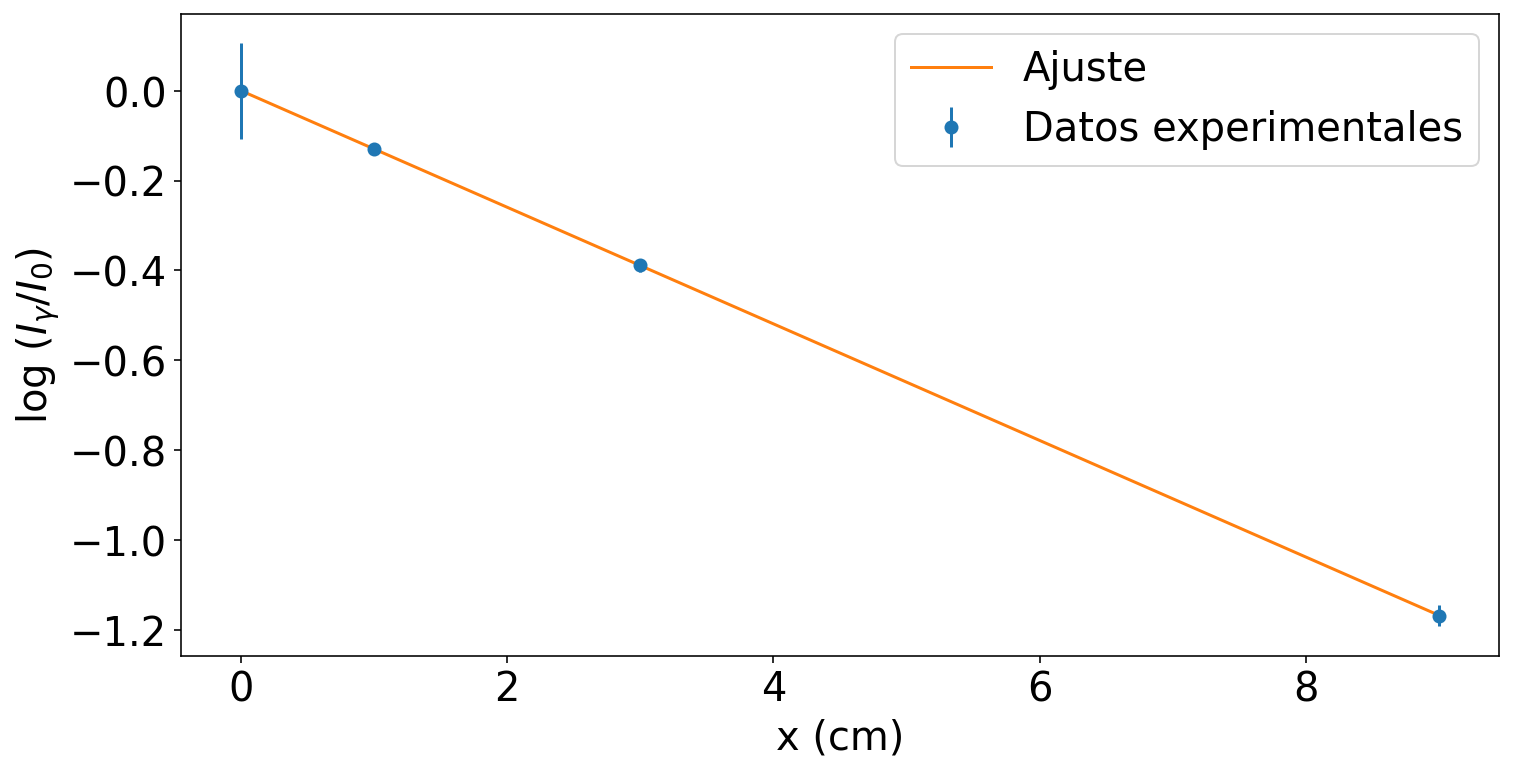

In [385]:
#Graficando
fig, ax = plt.subplots(1,1,figsize=(cm2inch(30.0),cm2inch(15.0)))

datos=ax.errorbar(x_1, I, yerr=I_uncloga,fmt='o')
datos.set_label('Datos experimentales')

recta_fit,=ax.plot(x_1,linear_fit)
recta_fit.set_label('Ajuste')

ax.set_xlabel('x (cm)')
ax.set_ylabel('log $(I_{\gamma}/I_{0})$')
ax.legend()
plt.savefig("ajuste-parafina.png", dpi=150);

In [386]:
statsLinear_tabla(popt2,pcov2)

      m    	    b
-0.130(0.000) 	 0.000(0.001)


In [387]:
ufloat(0.130,0.001)/ufloat(0.081,0)

1.6049382716049383+/-0.012345679012345678

In [396]:
log(34592/36720)/(0.3)

-0.19899708098497307